In [21]:
pip -q install rdkit-pypi

In [22]:
pip -q install Pillow

In [23]:
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import numpy as np
import tensorflow as tf
from tensorflow import keras

RDLogger.DisableLog("rdApp.*")

SMILES: Cn1cncc1O
Num heavy atoms: 7


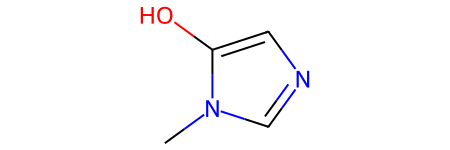

In [24]:
csv_path = tf.keras.utils.get_file(
    "qm9.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
)

data = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# Let's look at a molecule of the dataset
smiles = data[1000]
print("SMILES:", smiles)
molecule = Chem.MolFromSmiles(smiles)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())
molecule

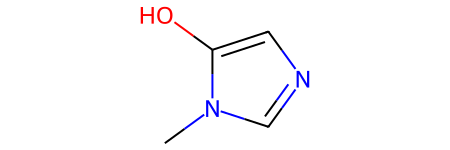

In [25]:
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

NUM_ATOMS = 9  # Maximum number of atoms
ATOM_DIM = 4 + 1  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 64  # Size of the latent space


def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule


# Test helper functions
graph_to_molecule(smiles_to_graph(smiles))

In [26]:
adjacency_tensor, feature_tensor = [], []
for smiles in data[::10]:
    adjacency, features = smiles_to_graph(smiles)
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

adjacency_tensor.shape = (13389, 5, 9, 9)
feature_tensor.shape = (13389, 9, 5)


In [27]:
def GraphGenerator(
    dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape,
):
    z = keras.layers.Input(shape=(LATENT_DIM,))
    # Propagate through one or more densely connected layers
    x = z
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")


generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 128)                  8320      ['input_4[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 128)                  0         ['dense_8[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 256)                  33024     ['dropout_5[0][0]']           
                                                                                          

In [28]:
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


def GraphDiscriminator(
    gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape
):

    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # For each molecule, output a single scalar value expressing the
    # "realness" of the inputted molecule
    x_out = keras.layers.Dense(1, dtype="float32")(x)

    return keras.Model(inputs=[adjacency, features], outputs=x_out)


discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 5, 9, 9)]            0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 9, 5)]               0         []                            
                                                                                                  
 relational_graph_conv_laye  (None, 9, 128)               3200      ['input_5[0][0]',             
 r_4 (RelationalGraphConvLa                                          'input_6[0][0]']             
 yer)                                                                                             
                                                                                            

In [29]:
class GraphWGAN(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        discriminator_steps=1,
        generator_steps=1,
        gp_weight=10,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):

        if isinstance(inputs[0], tuple):
            inputs = inputs[0]

        graph_real = inputs

        self.batch_size = tf.shape(inputs[0])[0]

        # Train the discriminator for one or more steps
        for _ in range(self.discriminator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_discriminator(graph_real, graph_generated)

            grads = tape.gradient(loss, self.discriminator.trainable_weights)
            self.optimizer_discriminator.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            self.metric_discriminator.update_state(loss)

        # Train the generator for one or more steps
        for _ in range(self.generator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_generator(graph_generated)

                grads = tape.gradient(loss, self.generator.trainable_weights)
                self.optimizer_generator.apply_gradients(
                    zip(grads, self.generator.trainable_weights)
                )
                self.metric_generator.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def _loss_discriminator(self, graph_real, graph_generated):
        logits_real = self.discriminator(graph_real, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        loss_gp = self._gradient_penalty(graph_real, graph_generated)
        return loss + loss_gp * self.gp_weight

    def _loss_generator(self, graph_generated):
        logits_generated = self.discriminator(graph_generated, training=True)
        return -tf.reduce_mean(logits_generated)

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

In [30]:
wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)

wgan.compile(
    optimizer_generator=keras.optimizers.Nadam(5e-4),
    optimizer_discriminator=keras.optimizers.Adam(5e-4),
)

wgan.fit([adjacency_tensor, feature_tensor], epochs=10, batch_size=32)

Epoch 1/10
419/419 [==============================] - 109s 212ms/step - loss_gen: 2.4627 - loss_dis: -5.6999
Epoch 2/10
419/419 [==============================] - 96s 229ms/step - loss_gen: 1.0391 - loss_dis: -1.5242
Epoch 3/10
419/419 [==============================] - 96s 230ms/step - loss_gen: 1.4037 - loss_dis: -1.9880
Epoch 4/10
419/419 [==============================] - 94s 224ms/step - loss_gen: 1.4313 - loss_dis: -2.2461
Epoch 5/10
419/419 [==============================] - 93s 221ms/step - loss_gen: 1.3591 - loss_dis: -2.1719
Epoch 6/10
419/419 [==============================] - 93s 223ms/step - loss_gen: 0.4643 - loss_dis: -1.5090
Epoch 7/10
419/419 [==============================] - 93s 222ms/step - loss_gen: 0.7976 - loss_dis: -1.7035
Epoch 8/10
419/419 [==============================] - 90s 214ms/step - loss_gen: 0.3542 - loss_dis: -1.5129
Epoch 9/10
419/419 [==============================] - 93s 222ms/step - loss_gen: 0.7764 - loss_dis: -1.7458
Epoch 10/10
419/419 [======

2/2 [==============================] - 0s 8ms/step


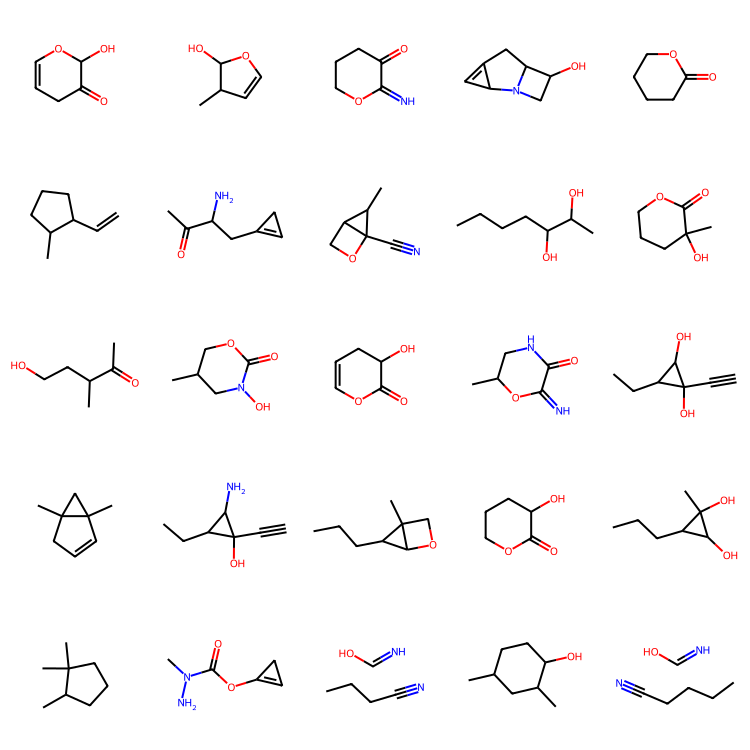

In [31]:
from rdkit.Chem import MolToSmiles

def sample(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)
    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    # obtain one-hot encoded feature tensor
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)

    # Generate unique molecules based on SMILES
    unique_molecules = set()
    for i in range(batch_size):
        molecule = graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        if molecule is not None:
            smiles = MolToSmiles(molecule)
            unique_molecules.add(smiles)

    unique_molecules = list(unique_molecules)[:batch_size]

    return [
        Chem.MolFromSmiles(smiles) for smiles in unique_molecules
    ]

# Generate and display unique molecules
molecules = sample(wgan.generator, batch_size=48)
MolsToGridImage(
    [m for m in molecules if m is not None][:25], molsPerRow=5, subImgSize=(150, 150)
)
